In [ ]:
# Run these commands in the terminal to create conda environment. 
# Make sure onda is installed on your system before intiating this step.
# conda create --name AIProjectGroup1 python=3.10 -y
# conda activate AIProjectGroup1

In [ ]:
#install required libraries 
%pip install numpy opencv-python tensorflow matplotlib imgaug scikit-learn seaborn


In [ ]:
# Libraries importance

import os
import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV3Small, EfficientNetV2B0, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [ ]:
# Define Dataset path. Note: please change it to your path!
dataset_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/mrleyedataset'  
categories = [ 'Close-Eyes', 'Open-Eyes']

# Batch size for processing images during training and evaluation
batch_size = 16

# Standard image size 
img_size = (64, 64)

In [ ]:
def load_data(dataset_dir, categories, max_images_per_class_0, max_images_per_class_1):
    """
    Load and preprocess images from the dataset with class-specific limits per patient.

    Parameters:
    - dataset_dir: Path to the dataset directory.
    - categories: List of class labels 
    - max_images_per_class_0: Maximum images allowed for class 0 (e.g., Close-Eyes) per patient.
    - max_images_per_class_1: Maximum images allowed for class 1 (e.g., Open-Eyes) per patient.

    Returns:
    - data: Array of preprocessed images.
    - labels: Array of labels corresponding to the images.
    - groups: Array of patient IDs corresponding to the images.
    """
    data, labels, groups = [], [], []
    patient_image_count = {}  # Tracks the number of images per class for each patient

    for idx, category in enumerate(categories):
        category_path = os.path.join(dataset_dir, category)
        for img_name in sorted(os.listdir(category_path)):
            img_path = os.path.join(category_path, img_name)
            patient_id = img_name.split('_')[0]  # Extract patient ID from the file name

            # Initialize counts for each patient if not already done
            if patient_id not in patient_image_count:
                patient_image_count[patient_id] = [0, 0]  # [class_0_count, class_1_count]

            # Enforce class-specific limits per patient
            if idx == 0 and patient_image_count[patient_id][0] >= max_images_per_class_0:
                continue
            elif idx == 1 and patient_image_count[patient_id][1] >= max_images_per_class_1:
                continue

            # Attempt to load the image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_name}")
                continue

            # Resize and convert to RGB
            img = cv2.cvtColor(cv2.resize(img, img_size), cv2.COLOR_BGR2RGB)

            # Add the processed image to the lists
            data.append(img)
            labels.append(idx)  # 0 for Close-Eyes, 1 for Open-Eyes
            groups.append(patient_id)
            patient_image_count[patient_id][idx] += 1  # Increment count for this patient and class

    # # Debug: Print final counts for each patient
    # print("\nFinal Patient Counts:")
    # for patient_id, counts in patient_image_count.items():
    #     print(f"Patient {patient_id}: {counts[0]} Close-Eyes, {counts[1]} Open-Eyes")

    return np.array(data), np.array(labels), np.array(groups)

# Invoke load_data function 
data, labels, groups = load_data(dataset_dir, categories, max_images_per_class_0= 50, max_images_per_class_1=54)

# Print summary of loaded data
print(f"\nTotal images loaded: {len(data)}")
print(f"Number of Close-Eyes images: {np.sum(labels == 0)}")
print(f"Number of Open-Eyes images: {np.sum(labels == 1)}")



Total images loaded: 3497
Number of Close-Eyes images: 1759
Number of Open-Eyes images: 1738


In [17]:
# Print the total number of images in each class
print(f"Open-Eyes: {np.sum(labels == 1)} images, Close-Eyes: {np.sum(labels == 0)} images")

def count_patients_and_images(labels, groups, label_name):
    """
    Count the number of unique patients and their corresponding images for a given class.

    Parameters:
    - labels: Array of class labels for the dataset.
    - groups: Array of patient IDs corresponding to each image.
    - label_name: The class index to filter by (0 for Close-Eyes, 1 for Open-Eyes).
    """

    # Count the number of images per patient for the specified class
    patient_counts = Counter(groups[labels == label_name])

    # Print the class name and patient statistics
    print(f"\nClass '{categories[label_name]}':")
    print(f"Total unique patients: {len(patient_counts)}")
    for patient_id, count in patient_counts.items():
        print(f"Patient {patient_id}: {count} images")

# Count and display patient and image stats for each class
count_patients_and_images(labels, groups, label_name=1)  # Open-Eyes
count_patients_and_images(labels, groups, label_name=0)  # Close-Eyes

def balance_data(data, labels, groups):
    """
    Balance the dataset by sampling an equal number of images from each class.

    Parameters:
    - data: Array of image data.
    - labels: Array of class labels.
    - groups: Array of patient IDs corresponding to each image.

    Returns:
    - Balanced data, labels, and groups arrays.
    """
    # Get indices of each class
    open_eye_indices = np.where(labels == 1)[0]
    close_eye_indices = np.where(labels == 0)[0]

    # Determine the minimum number of samples between the two classes
    min_samples = min(len(open_eye_indices), len(close_eye_indices))
    
    # Randomly sample the same number of images from both classes
    balanced_indices = np.hstack([np.random.choice(open_eye_indices, min_samples, replace=False),
                                  np.random.choice(close_eye_indices, min_samples, replace=False)])
    
    # Return the balanced dataset
    return data[balanced_indices], labels[balanced_indices], groups[balanced_indices]

data, labels, groups = balance_data(data, labels, groups)
print(f"\nBalanced dataset size: {len(data)}")
print(f"Balanced Open-Eyes: {np.sum(labels == 1)} images, Balanced Close-Eyes: {np.sum(labels == 0)} images")

Open-Eyes: 1738 images, Close-Eyes: 1759 images

Class 'Open-Eyes':
Total unique patients: 35
Patient s0001: 54 images
Patient s0002: 54 images
Patient s0003: 54 images
Patient s0005: 28 images
Patient s0006: 1 images
Patient s0007: 11 images
Patient s0009: 24 images
Patient s0010: 54 images
Patient s0011: 54 images
Patient s0012: 54 images
Patient s0013: 54 images
Patient s0014: 54 images
Patient s0015: 54 images
Patient s0016: 54 images
Patient s0017: 54 images
Patient s0018: 54 images
Patient s0019: 54 images
Patient s0020: 54 images
Patient s0021: 54 images
Patient s0022: 54 images
Patient s0023: 54 images
Patient s0024: 54 images
Patient s0025: 54 images
Patient s0026: 54 images
Patient s0027: 54 images
Patient s0028: 54 images
Patient s0029: 54 images
Patient s0030: 54 images
Patient s0031: 54 images
Patient s0032: 54 images
Patient s0033: 54 images
Patient s0034: 54 images
Patient s0035: 54 images
Patient s0036: 54 images
Patient s0037: 54 images

Class 'Close-Eyes':
Total uniqu

In [18]:
def split_data(data, labels, groups):
    """
    Split the dataset into training, validation, and test sets with no overlap of patients.

    Parameters:
    - data: Array of image data.
    - labels: Array of class labels.
    - groups: Array of patient IDs corresponding to each image.

    Returns:
    - train_data_final: Training data images.
    - val_data: Validation data images.
    - test_data: Test data images.
    - train_labels_final: Training data labels.
    - val_labels: Validation data labels.
    - test_labels: Test data labels.
    - train_groups_final: Training data patient IDs.
    - val_groups: Validation data patient IDs.
    - test_groups: Test data patient IDs.
    """
      
    # Split the dataset into training and test sets.
    splitter = GroupShuffleSplit(test_size=0.11, n_splits=1, random_state=42)
    train_idx, test_idx = next(splitter.split(data, labels, groups))
    
    # Extract training and test data, labels, and groups
    train_data, test_data = data[train_idx], data[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]
    train_groups, test_groups = groups[train_idx], groups[test_idx]
    
    # Further split the training set into training and validation sets 
    val_splitter = GroupShuffleSplit(test_size=0.07, n_splits=1, random_state=42)
    train_idx, val_idx = next(val_splitter.split(train_data, train_labels, train_groups))
    
    # Extract final training and validation sets
    train_data_final, val_data = train_data[train_idx], train_data[val_idx]
    train_labels_final, val_labels = train_labels[train_idx], train_labels[val_idx]
    val_groups = train_groups[val_idx]           
    train_groups_final = train_groups[train_idx] 
    
    # Shuffle each subset independently
    train_data_final, train_labels_final, train_groups_final = shuffle(train_data_final, train_labels_final, train_groups_final, random_state=42)
    val_data, val_labels, val_groups = shuffle(val_data, val_labels, val_groups, random_state=42)
    test_data, test_labels, test_groups = shuffle(test_data, test_labels, test_groups, random_state=42)
    
    # Print class distribution in each split
    print(f"Training Set: Open-Eyes: {np.sum(train_labels_final == 1)}, Close-Eyes: {np.sum(train_labels_final == 0)}")
    print(f"Validation Set: Open-Eyes: {np.sum(val_labels == 1)}, Close-Eyes: {np.sum(val_labels == 0)}")
    print(f"Test Set: Open-Eyes: {np.sum(test_labels == 1)}, Close-Eyes: {np.sum(test_labels == 0)}")
    
    return train_data_final, val_data, test_data, train_labels_final, val_labels, test_labels, train_groups_final, val_groups, test_groups

train_data, val_data, test_data, train_labels, val_labels, test_labels, train_groups, val_groups, test_groups = split_data(data, labels, groups)

Training Set: Open-Eyes: 1332, Close-Eyes: 1378
Validation Set: Open-Eyes: 162, Close-Eyes: 113
Test Set: Open-Eyes: 244, Close-Eyes: 247


In [19]:
def check_data_leakage(train_groups, val_groups, test_groups):
    """
    Check for data leakage by ensuring no overlap of patient IDs across training, validation, and test sets.

    Parameters:
    - train_groups: Array of patient IDs in the training set.
    - val_groups: Array of patient IDs in the validation set.
    - test_groups: Array of patient IDs in the test set.

    Returns:
    - None: Prints whether data leakage is detected or not.
    """
        
    leakage_detected = False
    
    # Check for overlap between training and validation sets
    if len(np.intersect1d(train_groups, val_groups)) > 0:
        print("Data Leakage Detected: Train and Validation sets have overlapping patients.")
        leakage_detected = True
    
    # Check for overlap between training and test sets
    if len(np.intersect1d(train_groups, test_groups)) > 0:
        print("Data Leakage Detected: Train and Test sets have overlapping patients.")
        leakage_detected = True
    
    # Check for overlap between validation and test sets
    if len(np.intersect1d(val_groups, test_groups)) > 0:
        print("Data Leakage Detected: Validation and Test sets have overlapping patients.")
        leakage_detected = True
    
    # Print "No Data Leakage Detected" only if no leakage was found
    if not leakage_detected:
        print("No Data Leakage Detected across splits.")

check_data_leakage(train_groups, val_groups, test_groups)

No Data Leakage Detected across splits.


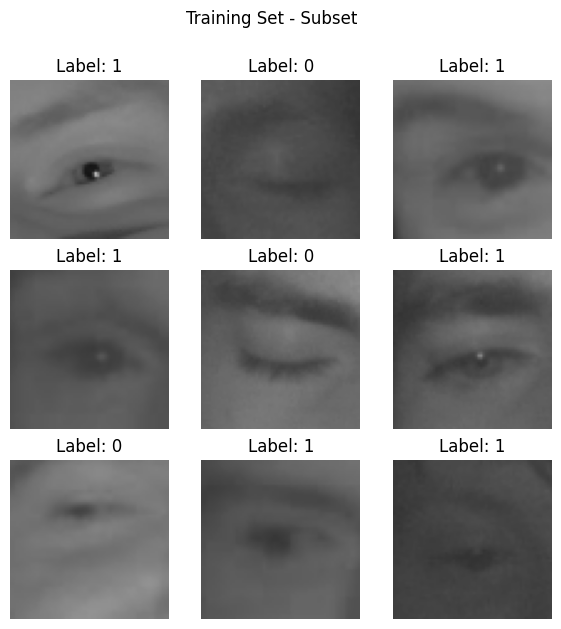

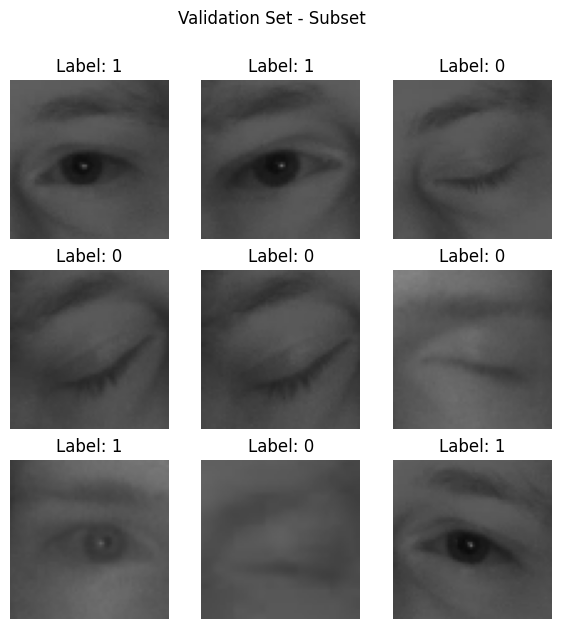

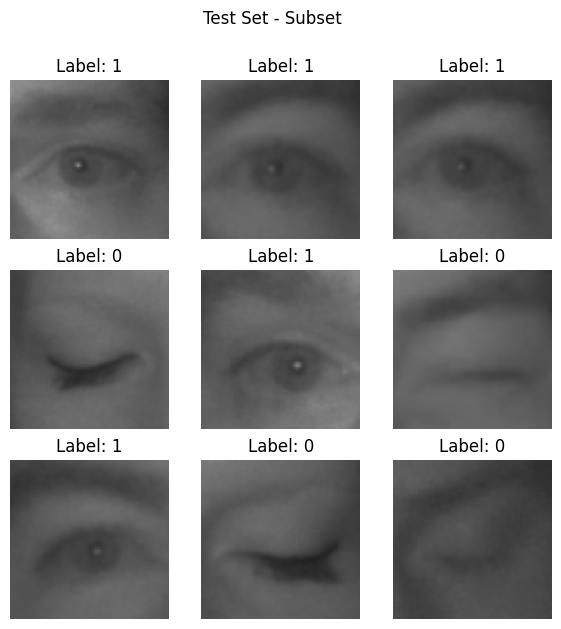

In [21]:
def display_images(images, labels, title, num_images=9):
    """
    Display a grid of images with their labels.

    Parameters:
    - images: Array of images to display.
    - labels: Corresponding labels for the images.
    - title: Title for the grid of images.
    - num_images: Number of images to display (default: 9).
    """
    # Set the figure size for the grid
    plt.figure(figsize=(7, 7))

    # Ensure we don't go out of bounds
    for i in range(min(num_images, len(images))):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display a subset of images from each split
# Training Set
display_images(train_data[9:18], train_labels[9:18], title="Training Set - Subset")

# Validation Set
display_images(val_data[9:18], val_labels[9:18], title="Validation Set - Subset")

# Test Set
display_images(test_data[9:18], test_labels[9:18], title="Test Set - Subset")



# No augumentation

In [13]:
print(f"Train Data Shape: {train_data.shape}, Train Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {val_data.shape}, Validation Labels Shape: {val_labels.shape}")
print(f"Test Data Shape: {test_data.shape}, Test Labels Shape: {test_labels.shape}")


Train Data Shape: (2710, 64, 64, 3), Train Labels Shape: (2710,)
Validation Data Shape: (273, 64, 64, 3), Validation Labels Shape: (273,)
Test Data Shape: (493, 64, 64, 3), Test Labels Shape: (493,)


In [23]:
# Define the base model using EfficientNetV2B0 with pre-trained ImageNet weights
# The top layer is excluded to allow customization for binary classification
base_model = EfficientNetV2B0(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the first 200 layers to retain pre-trained features and prevent updates during training
for layer in base_model.layers[:200]:  
    layer.trainable = False

# Add custom layers for binary classification
inputs = Input(shape=(64, 64, 3), name='image_input')  # Input layer
x = base_model(inputs)  # Pass input through the base model
x = GlobalAveragePooling2D()(x)  # Apply global average pooling to reduce feature dimensions
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Dense layer with L2 regularization
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Create the final model
model = Model(inputs, output)

# Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model checkpoint and early stopping
checkpoint = ModelCheckpoint('best_efficientnetv2b0_model.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)



#Train the model
history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=15,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8225 - loss: 2.1346 - val_accuracy: 0.9964 - val_loss: 0.6296
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 33s 384ms/step - accuracy: 0.9541 - loss: 0.5920 - val_accuracy: 0.9964 - val_loss: 0.2085
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 33s 381ms/step - accuracy: 0.9634 - loss: 0.2406 - val_accuracy: 0.9964 - val_loss: 0.0903
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - accuracy: 0.9714 - loss: 0.1461 - val_accuracy: 0.9964 - val_loss: 0.0654
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 314ms/step - accuracy: 0.9750 - loss: 0.1309 - val_accuracy: 0.9964 - val_loss: 0.0508
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 337ms/step - accuracy: 0.9788 - loss: 0.0979 - val_accuracy: 0.9927 - val_loss: 0.0406
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 337ms/step - accuracy: 0.9900 - loss: 0.0678 - val_accuracy: 0.9964 - val_loss: 0.0388
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 325ms/step - accuracy: 0.9801 - loss: 0.0753 - val_accura

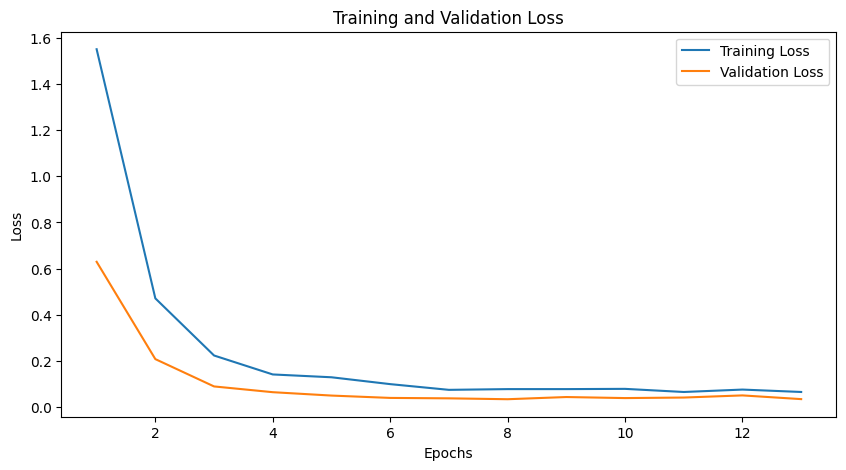

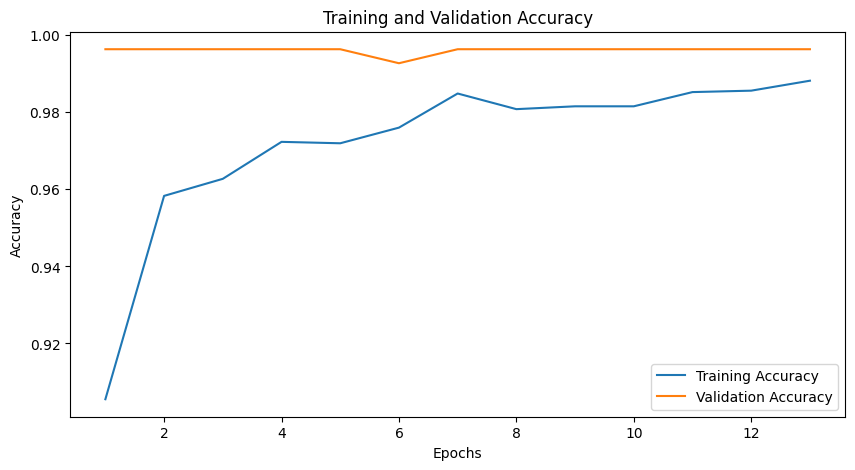

In [ ]:

# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Generate range for epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 704ms/step
F1 Score: 0.9491
Precision: 0.9433
Recall: 0.9549

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       247
           1       0.94      0.95      0.95       244

    accuracy                           0.95       491
   macro avg       0.95      0.95      0.95       491
weighted avg       0.95      0.95      0.95       491



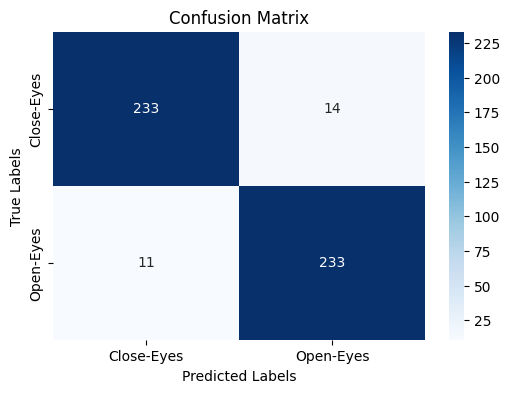

In [26]:
# Normalize test data
test_images = test_data

# Predict probabilities in bulk
y_pred_prob = model.predict(test_images, batch_size=batch_size)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Ensure test labels are 1D
y_true = test_labels

# # Debug shapes
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_true.shape)
# print("Predicted probabilities shape:", y_pred_prob.shape)
# print("Predicted labels shape:", y_pred.shape)

# # Ensure no shape mismatches
# assert len(y_true) == len(y_pred), "Mismatch between true labels and predicted labels!"

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Define the base model using MobileNetV3Small with pre-trained ImageNet weights
# Exclude the top layer for customization
base_model_eye = MobileNetV3Small(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the the first layers to retain pre-trained features
for layer in base_model_eye.layers[:60]:  # Freezing the first 60 layers
    layer.trainable = False

# Add custom layers for binary classification
eye_input = Input(shape=(64, 64, 3), name='eye_input')  # Input layer
x_eye = base_model_eye(eye_input)  # Pass input through the base model
x_eye = GlobalAveragePooling2D()(x_eye)  # Reduce feature dimensions using global average pooling
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_eye)  # Dense layer with L2 regularization
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Create the final model 
model = Model(inputs=[eye_input], outputs=output)

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy as a metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Model checkpoint and early stopping
checkpoint = ModelCheckpoint('best_mobilenet_eye_model.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

#Train the model
history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/Users/as/.local/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ eye_input (InputLayer)          │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 2, 2, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,105 (3.86 MB)

 Trainable params: 929,185 (3.54 MB)

 Non-trainable params: 83,920 (327.81 KB)

Epoch 1/20


/Users/as/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['eye_input']. Received: the structure of inputs=*
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.7594 - loss: 2.4073 - val_accuracy: 0.9527 - val_loss: 1.4230
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9660 - loss: 1.1650 - val_accuracy: 0.8945 - val_loss: 0.8954
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9858 - loss: 0.6409 - val_accuracy: 0.7673 - val_loss: 1.0492
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9847 - loss: 0.3639 - val_accuracy: 0.8327 - val_loss: 0.5103
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9921 - loss: 0.2032 - val_accuracy: 0.6691 - val_loss: 1.3598
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9892 - loss: 0.1319 - val_accuracy: 0.9527 - val_loss: 0.2432
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9878 - loss: 0.0915 - val_accuracy: 0.9964 - val_loss: 0.0970
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9891 - loss: 0.0710 - val_accuracy: 0.9855 - val_loss: 0.

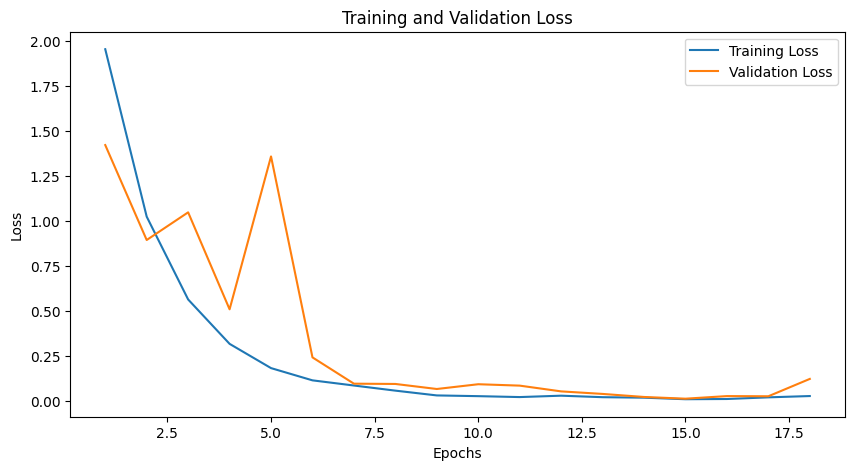

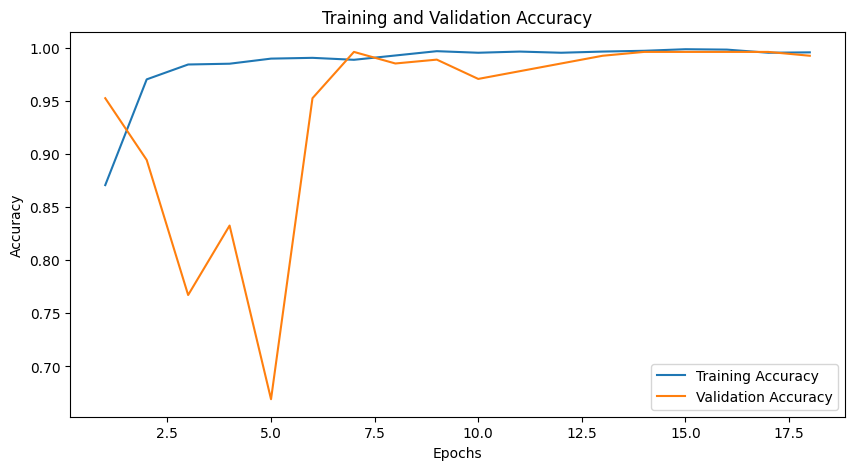

In [28]:
# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Generate range for epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/Users/as/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['eye_input']. Received: the structure of inputs=*
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 419ms/step
F1 Score: 0.9541
Precision: 0.9300
Recall: 0.9795

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       247
           1       0.93      0.98      0.95       244

    accuracy                           0.95       491
   macro avg       0.95      0.95      0.95       491
weighted avg       0.95      0.95      0.95       491



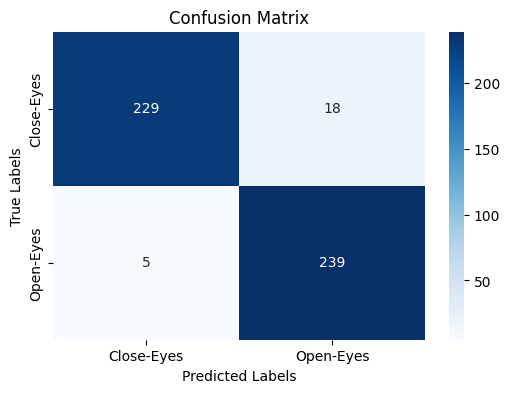

In [29]:
# Normalize test data
test_images = test_data

# Predict probabilities in bulk
y_pred_prob = model.predict(test_images, batch_size=batch_size)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5)

# Ensure test labels are 1D
y_true = test_labels

# # Debug shapes
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_true.shape)
# print("Predicted probabilities shape:", y_pred_prob.shape)
# print("Predicted labels shape:", y_pred.shape)

# # Ensure no shape mismatches
# assert len(y_true) == len(y_pred), "Mismatch between true labels and predicted labels!"

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Define the base model using ResNet50 with pre-trained ImageNet weights
# The top layer is excluded to allow customization for binary classification
base_model_eye = ResNet50(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the initial layers to retain pre-trained features
for layer in base_model_eye.layers[:140]:  # (first 140 layers)
    layer.trainable = False

# Add custom layers for binary classification
eye_input = Input(shape=(64, 64, 3), name='eye_input')
x_eye = base_model_eye(eye_input)
x_eye = GlobalAveragePooling2D()(x_eye)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_eye)
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
model = Model(inputs=eye_input, outputs=output)

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model checkpoint and early stopping 
checkpoint = ModelCheckpoint('best_resnet50_eye_model.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

#Train the model
history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=15,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8911 - loss: 2.0650 - val_accuracy: 0.8909 - val_loss: 82.0402
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - accuracy: 0.9835 - loss: 0.6035 - val_accuracy: 0.9964 - val_loss: 0.3619
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 297ms/step - accuracy: 0.9939 - loss: 0.2723 - val_accuracy: 0.9709 - val_loss: 0.1845
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 331ms/step - accuracy: 0.9895 - loss: 0.1594 - val_accuracy: 0.9891 - val_loss: 0.0991
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 330ms/step - accuracy: 0.9911 - loss: 0.0919 - val_accuracy: 0.9891 - val_loss: 0.0738
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 33s 388ms/step - accuracy: 0.9941 - loss: 0.0589 - val_accuracy: 0.9818 - val_loss: 0.0780
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.9992 - loss: 0.0325 - val_accuracy: 0.9564 - val_loss: 0.1226
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.9955 - loss: 0.0354 - val_accur

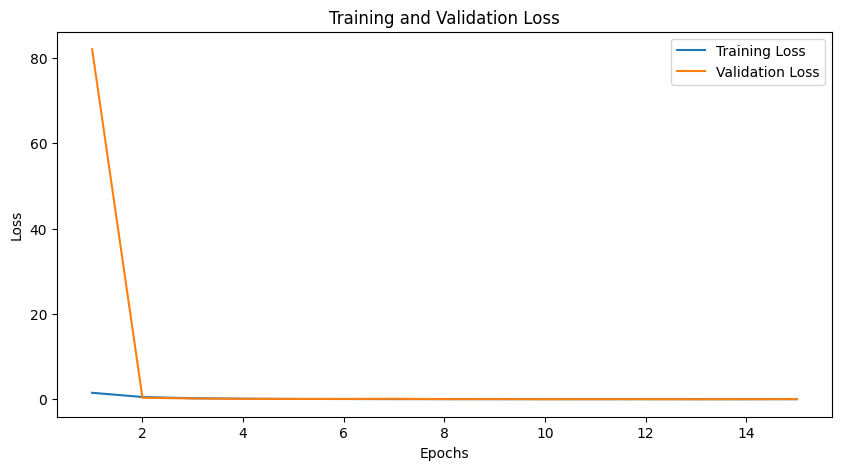

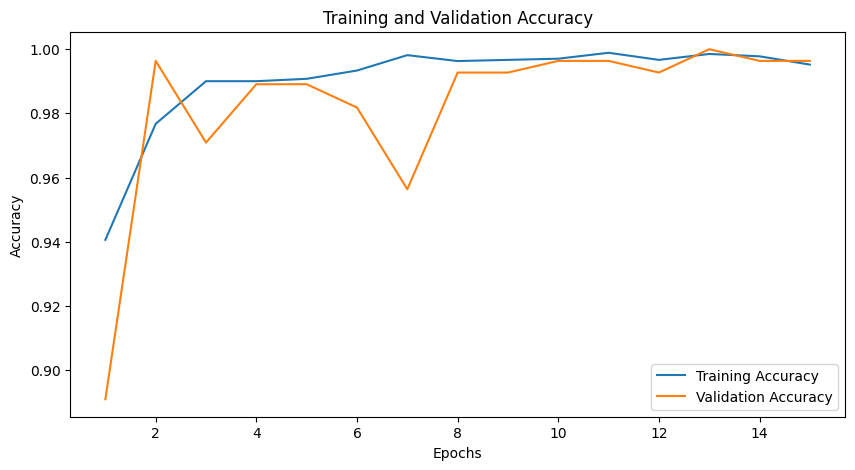

In [32]:
# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Generate range for epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 805ms/step
F1 Score: 0.9654
Precision: 0.9595
Recall: 0.9713

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       247
           1       0.96      0.97      0.97       244

    accuracy                           0.97       491
   macro avg       0.97      0.97      0.97       491
weighted avg       0.97      0.97      0.97       491



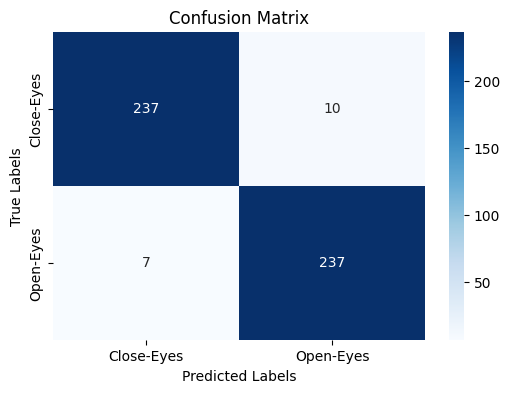

In [33]:
# Normalize test data
test_images = test_data

# Predict probabilities in bulk
y_pred_prob = model.predict(test_images, batch_size=batch_size)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5)
# Ensure test labels are 1D
y_true = test_labels

# # Debug shapes
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_true.shape)
# print("Predicted probabilities shape:", y_pred_prob.shape)
# print("Predicted labels shape:", y_pred.shape)

# # Ensure no shape mismatches
# assert len(y_true) == len(y_pred), "Mismatch between true labels and predicted labels!"

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Light augumentation

In [84]:
# Custom Data Generator with Augmentation for Training Data Only
class ImgAugDataGenerator(Sequence):
    """
    Custom data generator to handle large datasets with optional image augmentation.
    Designed for efficient batch processing during training.
    """
    def __init__(self, images, labels, batch_size, augmenter=None, shuffle=True):
        """
        Initialize the data generator.

        Parameters:
        - images: Array of input images.
        - labels: Array of corresponding labels.
        - batch_size: Number of images per batch.
        - augmenter: Optional augmenter to apply transformations (default: None).
        - shuffle: Whether to shuffle data at the end of each epoch (default: True).
        """
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augmenter = augmenter
        self.shuffle = shuffle
        self.indices = np.arange(len(self.images))
        self.on_epoch_end()

    def __len__(self):
        """
        Return the number of batches per epoch.
        """
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.

        Parameters:
        - index: Index of the batch.

        Returns:
        - batch_images: Batch of preprocessed images.
        - batch_labels: Corresponding labels for the batch.
        """
        # Generate indices for the current batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Select images and labels for the batch
        batch_images = self.images[batch_indices]
        batch_labels = self.labels[batch_indices]

        # Apply augmentation if an augmenter is defined
        if self.augmenter:
            batch_images = self.augmenter(images=batch_images)
        
        return batch_images, batch_labels

    def on_epoch_end(self):
        """
        Shuffle data indices at the end of each epoch if shuffling is enabled.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

# Define the augmenter for the training data
augmenter = iaa.Sequential([
    iaa.LinearContrast((0.9, 1.1)),              # Slight contrast adjustments
    iaa.Multiply((0.95, 1.05)),                  # Subtle brightness changes
    iaa.Affine(rotate=(-3, 3)),                  # Small random rotations
    iaa.AdditiveGaussianNoise(scale=(0, 0.009)), # Add light noise to images
    iaa.Fliplr(0.3),                             # 30% chance of horizontal flip
    iaa.GaussianBlur(sigma=(0, 0.009))           # Optional slight blur
])


In [51]:
batch_size = 16
train_gen = ImgAugDataGenerator(train_data, train_labels, batch_size, augmenter)  
val_gen = ImgAugDataGenerator(val_data, val_labels, batch_size, augmenter=None, shuffle=False)  # No augmentation for validation
test_gen = ImgAugDataGenerator(test_data, test_labels, batch_size, augmenter=None, shuffle=False)  # No augmentation for test

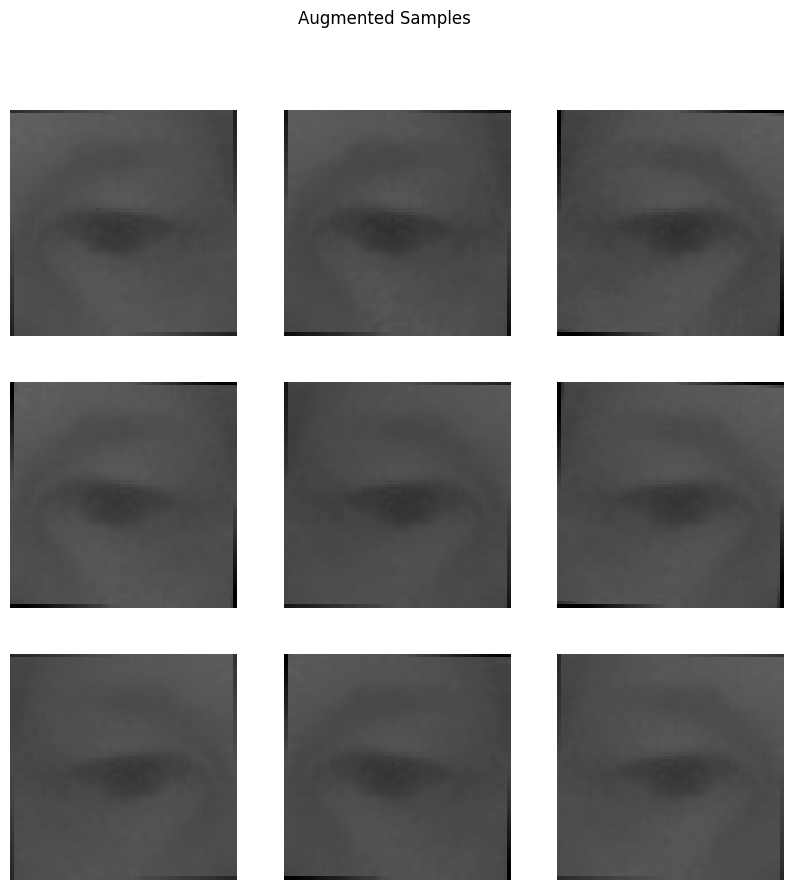

Training Set: 1332 ones and 1378 zeros
Validation Set: 162 ones and 113 zeros
Test Set: 244 ones and 247 zeros
Train Labels: 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0

In [52]:
#  Visualize a sample augmented image from the training set
sample_image = train_data[5]
sample_image = np.expand_dims(sample_image, 0)  # Add batch dimension for augmentation

# Apply augmentation to the same image multiple times
augmented_images = augmenter(images=sample_image.repeat(9, axis=0))  # Generate 9 variations

# Plot the augmented images to visualize the augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Samples")
plt.show()

# Count the number of ones and zeros in each subset
train_ones = np.sum(train_labels == 1)
train_zeros = np.sum(train_labels == 0)

val_ones = np.sum(val_labels == 1)
val_zeros = np.sum(val_labels == 0)

test_ones = np.sum(test_labels == 1)
test_zeros = np.sum(test_labels == 0)

# Print the class distribution in each dataset split
print(f"Training Set: {train_ones} ones and {train_zeros} zeros")
print(f"Validation Set: {val_ones} ones and {val_zeros} zeros")
print(f"Test Set: {test_ones} ones and {test_zeros} zeros")

# Print all labels in the training, validation, and test sets
print("Train Labels:", ' '.join(map(str, train_labels)))
print("Validation Labels:", ' '.join(map(str, val_labels)))
print("Test Labels:", ' '.join(map(str, test_labels)))

In [53]:
# Define the base model using EfficientNetV2B0 with pre-trained ImageNet weights
# The top layer is excluded to allow customization for binary classification
base_model = EfficientNetV2B0(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the first 200 layers to retain pre-trained features and prevent updates during training
for layer in base_model.layers[:200]:  
    layer.trainable = False

# Add custom layers for binary classification
inputs = Input(shape=(64, 64, 3), name='image_input')  # Input layer
x = base_model(inputs)  # Pass input through the base model
x = GlobalAveragePooling2D()(x)  # Apply global average pooling to reduce feature dimensions
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Dense layer with L2 regularization
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Create the final model
model = Model(inputs, output)

# Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model checkpoint and early stopping
checkpoint = ModelCheckpoint('best_efficientnetv2b0_model_light.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

#Train the model
history = model.fit(
    train_gen,  # Training data generator
    validation_data= val_gen,  # Validation data generator
    epochs=15, # Maximum number of training epochs
    callbacks=[early_stopping, checkpoint] # Apply callbacks during training
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.8117 - loss: 1.9438 - val_accuracy: 0.9963 - val_loss: 0.4457
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 370ms/step - accuracy: 0.9338 - loss: 0.4466 - val_accuracy: 0.9926 - val_loss: 0.1376
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 344ms/step - accuracy: 0.9418 - loss: 0.2436 - val_accuracy: 1.0000 - val_loss: 0.0613
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - accuracy: 0.9504 - loss: 0.1996 - val_accuracy: 1.0000 - val_loss: 0.0612
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 324ms/step - accuracy: 0.9508 - loss: 0.1822 - val_accuracy: 0.9963 - val_loss: 0.0494
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - accuracy: 0.9546 - loss: 0.1842 - val_accuracy: 0.9890 - val_loss: 0.0908
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 292ms/step - accuracy: 0.9670 - loss: 0.1447 - val_accuracy: 0.9963 - val_loss: 0.0547
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 293ms/step - accuracy: 0.9681 - loss: 0.1

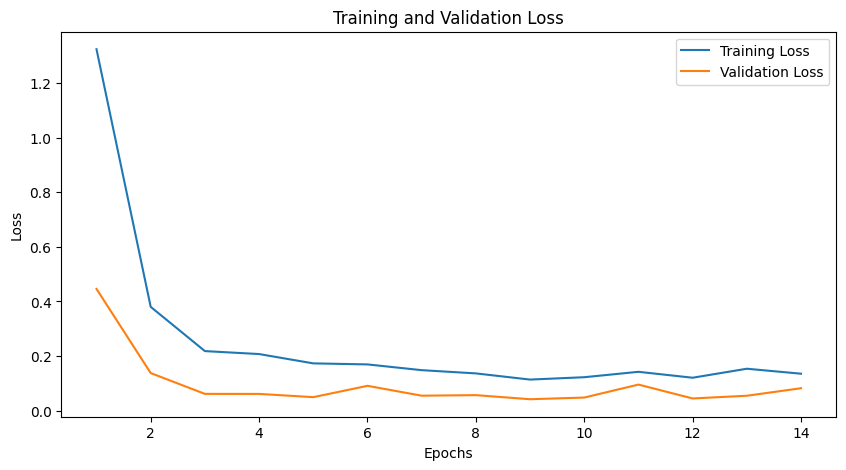

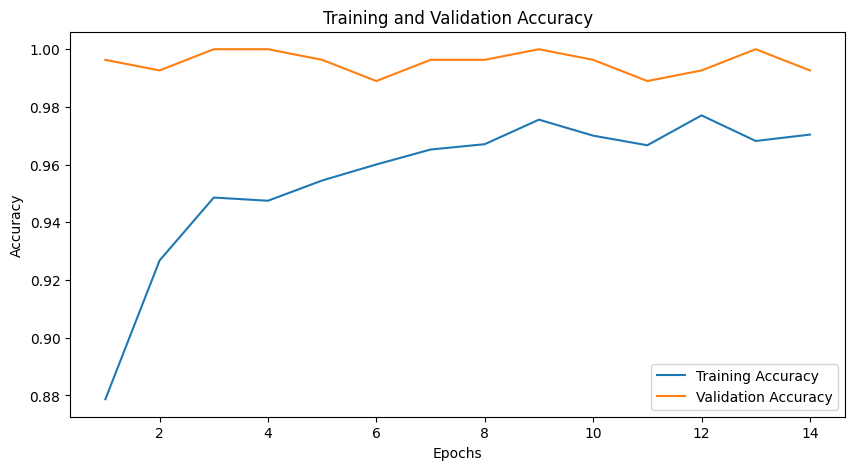

In [54]:
# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Generate range for epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step 
F1 Score: 0.9446
Precision: 0.9465
Recall: 0.9426

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       247
           1       0.95      0.94      0.94       244

    accuracy                           0.95       491
   macro avg       0.95      0.94      0.95       491
weighted avg       0.95      0.95      0.95       491



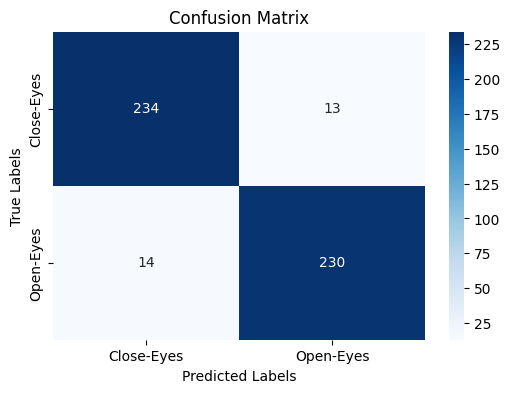

In [55]:
# Normalize test data
test_images = test_data

# Predict probabilities in bulk
y_pred_prob = model.predict(test_images, batch_size=batch_size)

y_pred = (y_pred_prob > 0.5)

# Ensure test labels are 1D
y_true = test_labels.reshape(-1)

# # Debug shapes
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_true.shape)
# print("Predicted probabilities shape:", y_pred_prob.shape)
# print("Predicted labels shape:", y_pred.shape)

# # Ensure no shape mismatches
# assert len(y_true) == len(y_pred), "Mismatch between true labels and predicted labels!"

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [63]:
# Define the base model using MobileNetV3Small with pre-trained ImageNet weights
# Exclude the top layer for customization
base_model_eye = MobileNetV3Small(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the the first layers to retain pre-trained features
for layer in base_model_eye.layers[:60]:  # Freezing the first 60 layers
    layer.trainable = False

# Add custom layers for binary classification
eye_input = Input(shape=(64, 64, 3), name='eye_input')  # Input layer
x_eye = base_model_eye(eye_input)  # Pass input through the base model
x_eye = GlobalAveragePooling2D()(x_eye)  # Reduce feature dimensions using global average pooling
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_eye)  # Dense layer with L2 regularization
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Create the final model 
model = Model(inputs=[eye_input], outputs=output)

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy as a metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Model checkpoint and early stopping
checkpoint = ModelCheckpoint('best_mobilenet_eye_model_light.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"\nTest Loss: {test_loss:.4f}")
print(f'Test Accuracy: {test_accuracy:.4f}')


/Users/as/.local/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ eye_input (InputLayer)          │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 2, 2, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,105 (3.86 MB)

 Trainable params: 929,185 (3.54 MB)

 Non-trainable params: 83,920 (327.81 KB)

Epoch 1/20


/Users/as/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['eye_input']. Received: the structure of inputs=*
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 908s 5s/step - accuracy: 0.7631 - loss: 2.1774 - val_accuracy: 0.9926 - val_loss: 0.8880
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.9434 - loss: 0.8596 - val_accuracy: 0.9963 - val_loss: 0.4063
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 0.9469 - loss: 0.4624 - val_accuracy: 0.9890 - val_loss: 0.2023
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.9689 - loss: 0.2345 - val_accuracy: 0.9963 - val_loss: 0.1059
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 634s 4s/step - accuracy: 0.9746 - loss: 0.1490 - val_accuracy: 0.9890 - val_loss: 0.0838
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.9727 - loss: 0.1164 - val_accuracy: 0.9743 - val_loss: 0.2152
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 462s 3s/step - accuracy: 0.9768 - loss: 0.0978 - val_accuracy: 0.9926 - val_loss: 0.0678
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.9823 - loss: 0.0761 - val_accuracy: 0.992

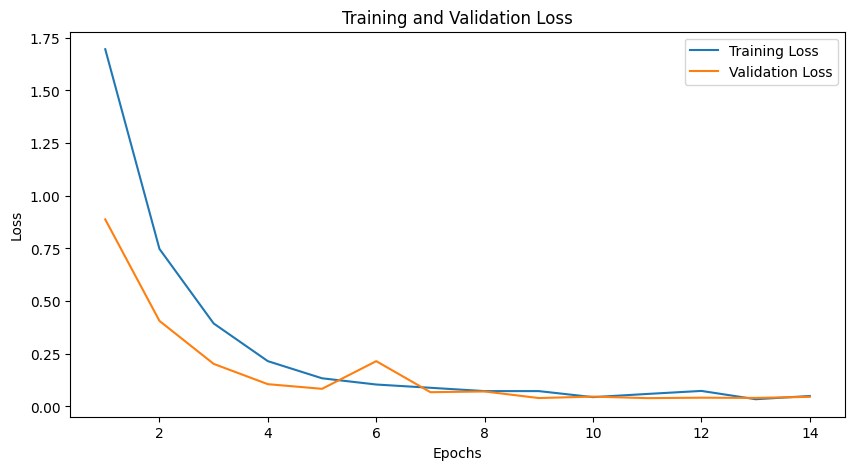

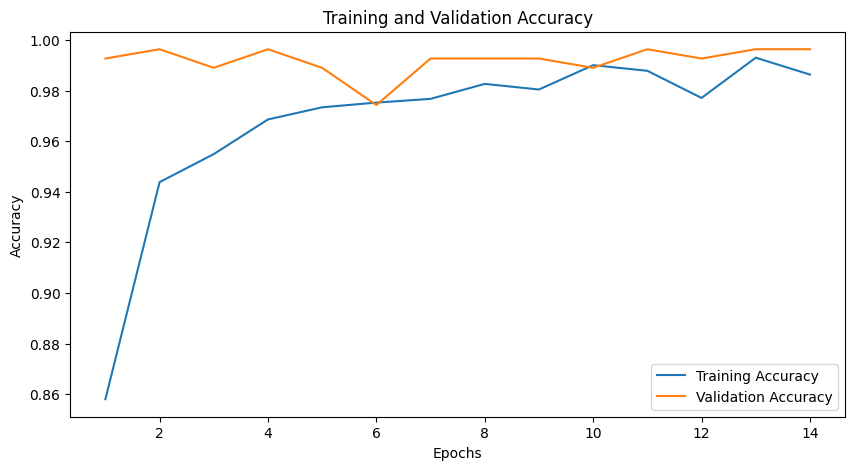

In [64]:
# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Generate range for epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 51s 848ms/step
F1 Score: 0.9584
Precision: 0.9272
Recall: 0.9918

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.96       247
           1       0.93      0.99      0.96       244

    accuracy                           0.96       491
   macro avg       0.96      0.96      0.96       491
weighted avg       0.96      0.96      0.96       491



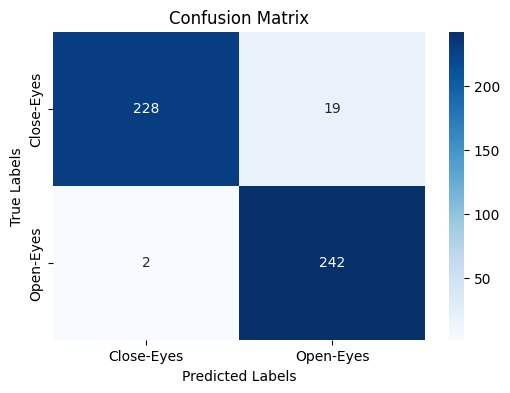

In [65]:
# Normalize test data
test_images = test_data

# Predict probabilities in bulk
y_pred_prob = model.predict(test_images, batch_size=batch_size)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5)

# Ensure test labels are 1D
y_true = test_labels

# # Debug shapes
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_true.shape)
# print("Predicted probabilities shape:", y_pred_prob.shape)
# print("Predicted labels shape:", y_pred.shape)

# # Ensure no shape mismatches
# assert len(y_true) == len(y_pred), "Mismatch between true labels and predicted labels!"

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [59]:
# Define the base model
base_model_eye = ResNet50(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the initial layers (experiment with different numbers of layers to unfreeze)
for layer in base_model_eye.layers[:140]:  # Freeze first 140 layers
    layer.trainable = False

# Add custom layers for binary classification
eye_input = Input(shape=(64, 64, 3), name='eye_input')
x_eye = base_model_eye(eye_input)
x_eye = GlobalAveragePooling2D()(x_eye)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_eye)
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
model = Model(inputs=eye_input, outputs=output)

# Compile the model (using default learning rate)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model checkpoint and early stopping with increased patience
checkpoint = ModelCheckpoint('best_resnet50_eye_model_light.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,  # Training data generator with augmentation
    validation_data=val_gen,  # Validation data generator
    epochs=15,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"\nTest Loss: {test_loss:.4f}")
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.8275 - loss: 1.9514 - val_accuracy: 0.9963 - val_loss: 0.3669
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 356ms/step - accuracy: 0.9452 - loss: 0.3795 - val_accuracy: 0.9963 - val_loss: 0.1302
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.9680 - loss: 0.1932 - val_accuracy: 1.0000 - val_loss: 0.0460
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.9670 - loss: 0.1270 - val_accuracy: 1.0000 - val_loss: 0.0334
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 281ms/step - accuracy: 0.9800 - loss: 0.0761 - val_accuracy: 0.9963 - val_loss: 0.0341
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.9840 - loss: 0.0795 - val_accuracy: 0.9926 - val_loss: 0.0282
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.9811 - loss: 0.0708 - val_accuracy: 0.9963 - val_loss: 0.5462
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.9684 - loss: 0.2

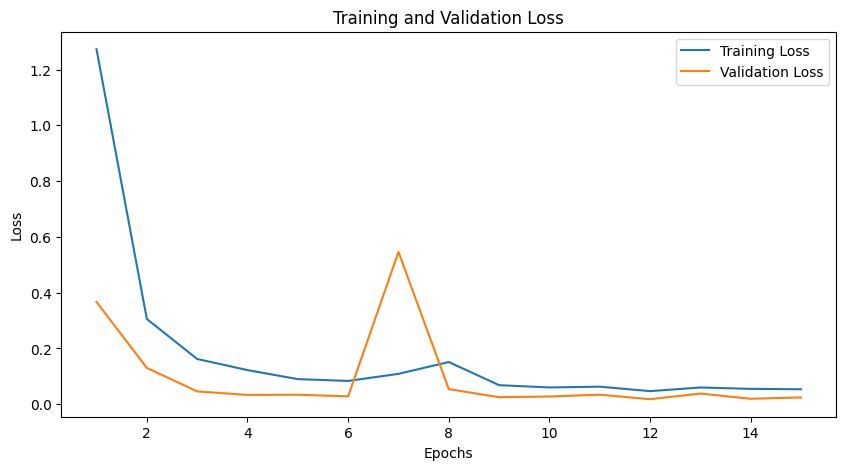

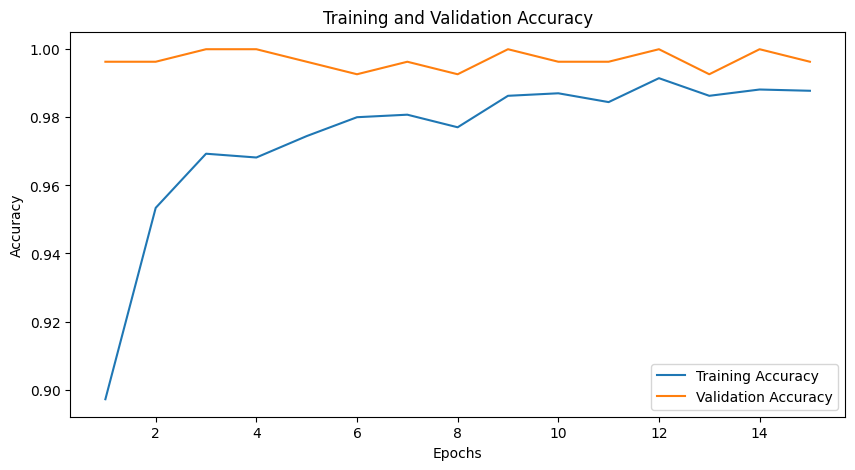

In [60]:
# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Generate range for epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step 
F1 Score: 0.9555
Precision: 0.9440
Recall: 0.9672

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       247
           1       0.94      0.97      0.96       244

    accuracy                           0.96       491
   macro avg       0.96      0.96      0.96       491
weighted avg       0.96      0.96      0.96       491



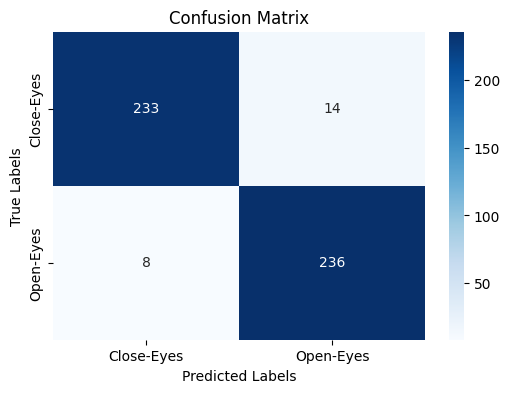

In [61]:
# Normalize test data
test_images = test_data

# Predict probabilities in bulk
y_pred_prob = model.predict(test_images, batch_size=batch_size)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5)

# Ensure test labels are 1D
y_true = test_labels

# # Debug shapes
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_true.shape)
# print("Predicted probabilities shape:", y_pred_prob.shape)
# print("Predicted labels shape:", y_pred.shape)

# # Ensure no shape mismatches
# assert len(y_true) == len(y_pred), "Mismatch between true labels and predicted labels!"

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Intense augumentation

In [66]:
# Custom Data Generator with Augmentation for Training Data Only
class ImgAugDataGenerator(Sequence):
    """
    Custom data generator to handle large datasets with optional image augmentation.
    Designed for efficient batch processing during training.
    """
    def __init__(self, images, labels, batch_size, augmenter=None, shuffle=True):
        """
        Initialize the data generator.

        Parameters:
        - images: Array of input images.
        - labels: Array of corresponding labels.
        - batch_size: Number of images per batch.
        - augmenter: Optional augmenter to apply transformations (default: None).
        - shuffle: Whether to shuffle data at the end of each epoch (default: True).
        """
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augmenter = augmenter
        self.shuffle = shuffle
        self.indices = np.arange(len(self.images))
        self.on_epoch_end()

    def __len__(self):
        """
        Return the number of batches per epoch.
        """
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.

        Parameters:
        - index: Index of the batch.

        Returns:
        - batch_images: Batch of preprocessed images.
        - batch_labels: Corresponding labels for the batch.
        """
        # Generate indices for the current batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Select images and labels for the batch
        batch_images = self.images[batch_indices]
        batch_labels = self.labels[batch_indices]

        # Apply augmentation if an augmenter is defined
        if self.augmenter:
            batch_images = self.augmenter(images=batch_images)
        
        return batch_images, batch_labels

    def on_epoch_end(self):
        """
        Shuffle data indices at the end of each epoch if shuffling is enabled.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

# Define the augmenter for training data
augmenter = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # Add Gaussian noise
    iaa.SaltAndPepper(0.06),                           # Add salt-and-pepper noise
    iaa.Multiply((0.3, 1.0)),                          # Adjust brightness
    iaa.GaussianBlur(sigma=(0.0, 5.0)),                # Apply Gaussian blur
    iaa.Fliplr(0.5),                                   # Apply horizontal flip (50% chance)
    iaa.Flipud(0.3)                                    # Apply vertical flip (20% chance)
])


In [67]:
batch_size = 16
train_gen = ImgAugDataGenerator(train_data, train_labels, batch_size, augmenter)  # No augmentation for training
val_gen = ImgAugDataGenerator(val_data, val_labels, batch_size, augmenter=None, shuffle=False)  # No augmentation for validation
test_gen = ImgAugDataGenerator(test_data, test_labels, batch_size, augmenter=None, shuffle=False)  # No augmentation for test

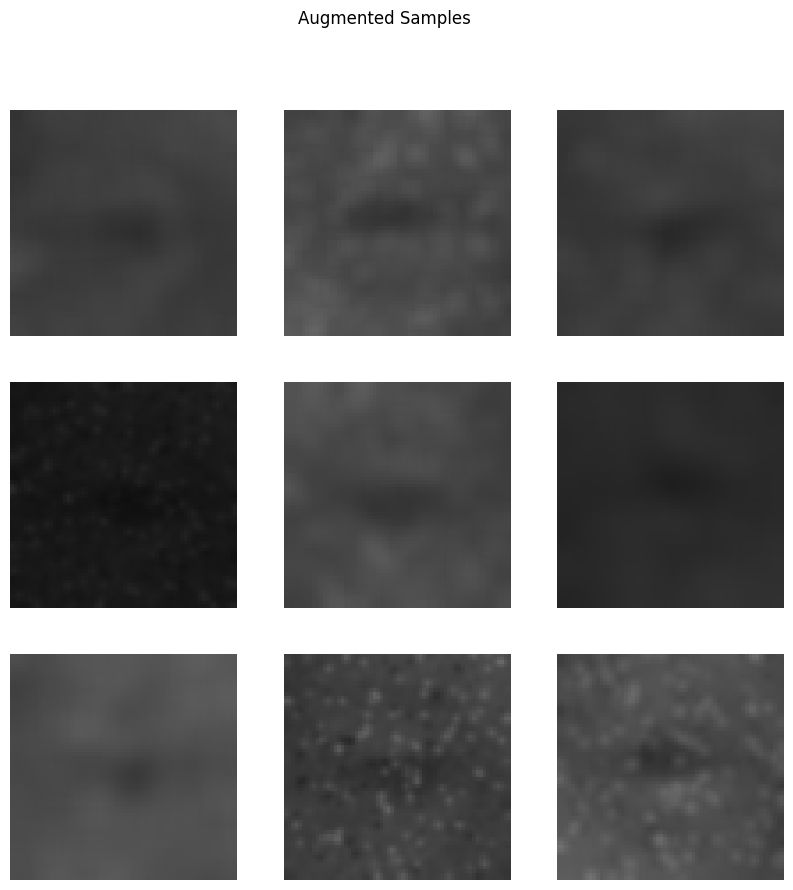

Training Set: 1332 ones and 1378 zeros
Validation Set: 162 ones and 113 zeros
Test Set: 244 ones and 247 zeros
Train Labels: 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0

In [68]:
#  Visualize a sample augmented image from the training set
sample_image = train_data[5]
sample_image = np.expand_dims(sample_image, 0)  # Add batch dimension for augmentation

# Apply augmentation to the same image multiple times
augmented_images = augmenter(images=sample_image.repeat(9, axis=0))  # Generate 9 variations

# Plot the augmented images to visualize the augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Samples")
plt.show()

# Count the number of ones and zeros in each subset
train_ones = np.sum(train_labels == 1)
train_zeros = np.sum(train_labels == 0)

val_ones = np.sum(val_labels == 1)
val_zeros = np.sum(val_labels == 0)

test_ones = np.sum(test_labels == 1)
test_zeros = np.sum(test_labels == 0)

# Print the class distribution in each dataset split
print(f"Training Set: {train_ones} ones and {train_zeros} zeros")
print(f"Validation Set: {val_ones} ones and {val_zeros} zeros")
print(f"Test Set: {test_ones} ones and {test_zeros} zeros")

# Print all labels in the training, validation, and test sets
print("Train Labels:", ' '.join(map(str, train_labels)))
print("Validation Labels:", ' '.join(map(str, val_labels)))
print("Test Labels:", ' '.join(map(str, test_labels)))

In [69]:
# Define the base model using EfficientNetV2B0 with pre-trained ImageNet weights
# The top layer is excluded to allow customization for binary classification
base_model = EfficientNetV2B0(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the first 200 layers to retain pre-trained features and prevent updates during training
for layer in base_model.layers[:200]:  
    layer.trainable = False

# Add custom layers for binary classification
inputs = Input(shape=(64, 64, 3), name='image_input')  # Input layer
x = base_model(inputs)  # Pass input through the base model
x = GlobalAveragePooling2D()(x)  # Apply global average pooling to reduce feature dimensions
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Dense layer with L2 regularization
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Create the final model
model = Model(inputs, output)

# Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model checkpoint and early stopping
checkpoint = ModelCheckpoint('best_efficientnetv2b0_model_intense.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

#Train the model
history = model.fit(
    train_gen,  # Training data generator
    validation_data= val_gen,  # Validation data generator
    epochs=15, # Maximum number of training epochs
    callbacks=[early_stopping, checkpoint] # Apply callbacks during training
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/15


/Users/as/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.6336 - loss: 2.2895 - val_accuracy: 0.7243 - val_loss: 1.1026
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 389ms/step - accuracy: 0.6931 - loss: 1.0499 - val_accuracy: 0.6801 - val_loss: 0.6747
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 343ms/step - accuracy: 0.7323 - loss: 0.7044 - val_accuracy: 0.8676 - val_loss: 0.4318
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 338ms/step - accuracy: 0.7641 - loss: 0.5977 - val_accuracy: 0.7390 - val_loss: 0.4643
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 346ms/step - accuracy: 0.7683 - loss: 0.5436 - val_accuracy: 0.9044 - val_loss: 0.3547
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.7727 - loss: 0.5262 - val_accuracy: 0.9485 - val_loss: 0.4987
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - accuracy: 0.7647 - loss: 0.5227 - val_accuracy: 0.8493 - val_loss: 0.4276
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - accuracy: 0.7868 - loss: 0.4978 - val_a

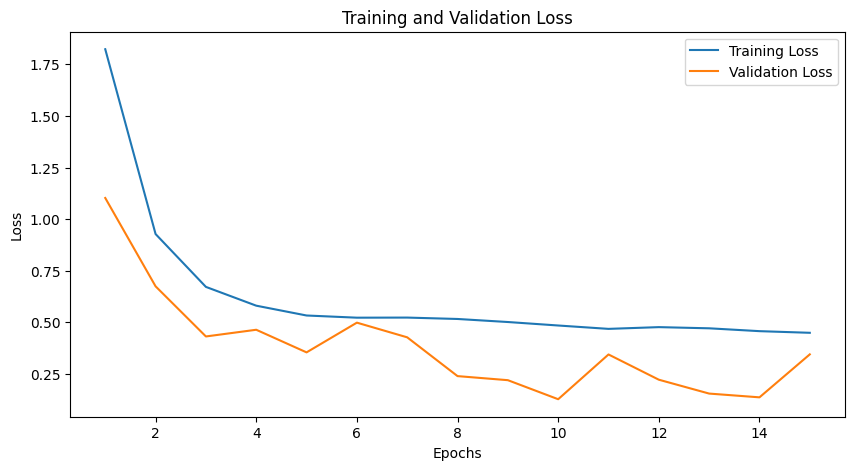

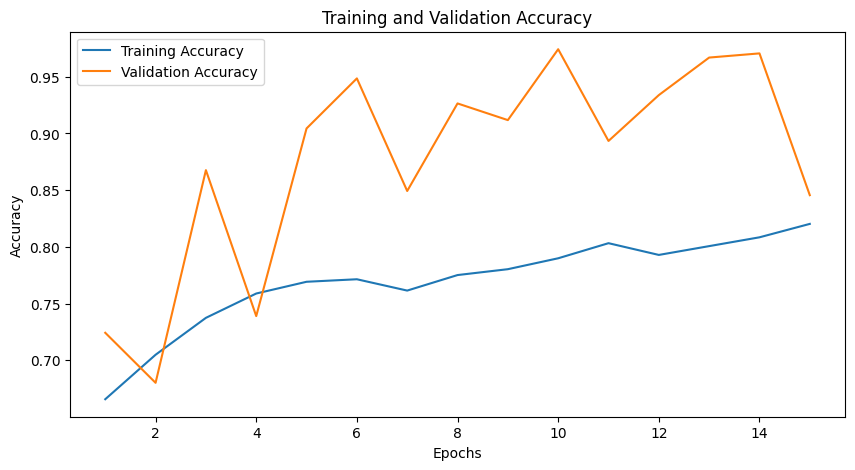

In [70]:
# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Generate range for epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step
F1 Score: 0.8862
Precision: 0.8638
Recall: 0.9098

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       247
           1       0.86      0.91      0.89       244

    accuracy                           0.88       491
   macro avg       0.88      0.88      0.88       491
weighted avg       0.89      0.88      0.88       491



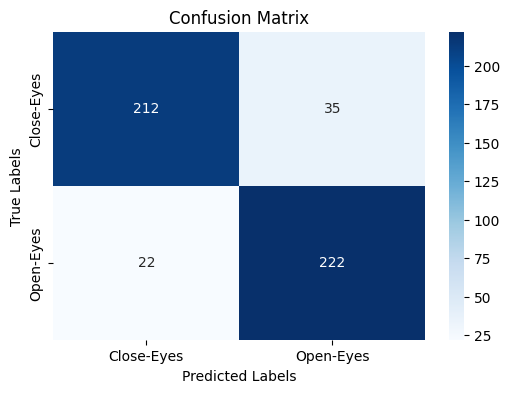

In [71]:
# Normalize test data
test_images = test_data

# Predict probabilities in bulk
y_pred_prob = model.predict(test_images, batch_size=batch_size)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5)

# Ensure test labels are 1D
y_true = test_labels

# # Debug shapes
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_true.shape)
# print("Predicted probabilities shape:", y_pred_prob.shape)
# print("Predicted labels shape:", y_pred.shape)

# # Ensure no shape mismatches
# assert len(y_true) == len(y_pred), "Mismatch between true labels and predicted labels!"

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [72]:
# Define the base model using MobileNetV3Small with pre-trained ImageNet weights
# Exclude the top layer for customization
base_model_eye = MobileNetV3Small(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the the first layers to retain pre-trained features
for layer in base_model_eye.layers[:60]:  # Freezing the first 60 layers
    layer.trainable = False

# Add custom layers for binary classification
eye_input = Input(shape=(64, 64, 3), name='eye_input')  # Input layer
x_eye = base_model_eye(eye_input)  # Pass input through the base model
x_eye = GlobalAveragePooling2D()(x_eye)  # Reduce feature dimensions using global average pooling
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_eye)  # Dense layer with L2 regularization
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Create the final model 
model = Model(inputs=[eye_input], outputs=output)

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy as a metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Model checkpoint and early stopping
checkpoint = ModelCheckpoint('best_mobilenet_eye_model_intense.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


/Users/as/.local/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ eye_input (InputLayer)          │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 2, 2, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,105 (3.86 MB)

 Trainable params: 929,185 (3.54 MB)

 Non-trainable params: 83,920 (327.81 KB)

Epoch 1/20


/Users/as/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['eye_input']. Received: the structure of inputs=*
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 850s 4s/step - accuracy: 0.6161 - loss: 2.5826 - val_accuracy: 0.6691 - val_loss: 1.5702
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 472s 3s/step - accuracy: 0.7557 - loss: 1.4417 - val_accuracy: 0.8199 - val_loss: 0.9095
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - accuracy: 0.8104 - loss: 0.9109 - val_accuracy: 0.7500 - val_loss: 0.8618
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.8487 - loss: 0.6377 - val_accuracy: 0.8787 - val_loss: 0.3944
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - accuracy: 0.8335 - loss: 0.5152 - val_accuracy: 0.8382 - val_loss: 0.4295
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - accuracy: 0.8527 - loss: 0.4131 - val_accuracy: 0.9191 - val_loss: 0.3087
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - accuracy: 0.8534 - loss: 0.4180 - val_accuracy: 0.9816 - val_loss: 0.0731
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 488s 3s/step - accuracy: 0.8667 - loss: 0.3486 - val_accuracy: 0.989

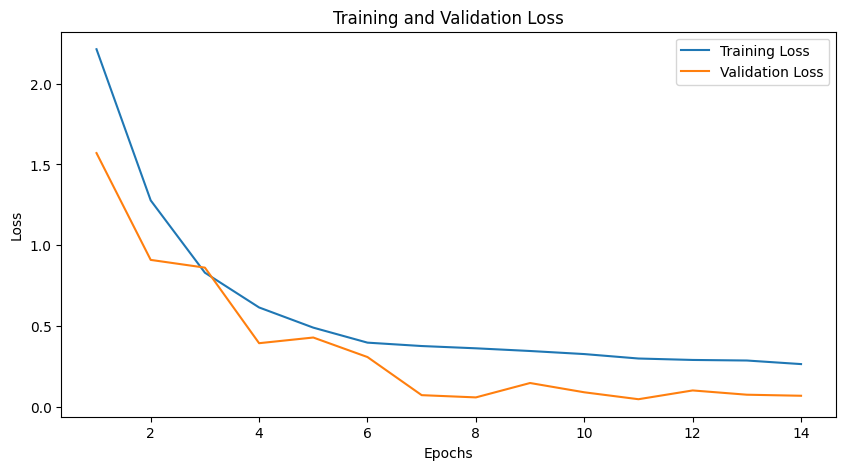

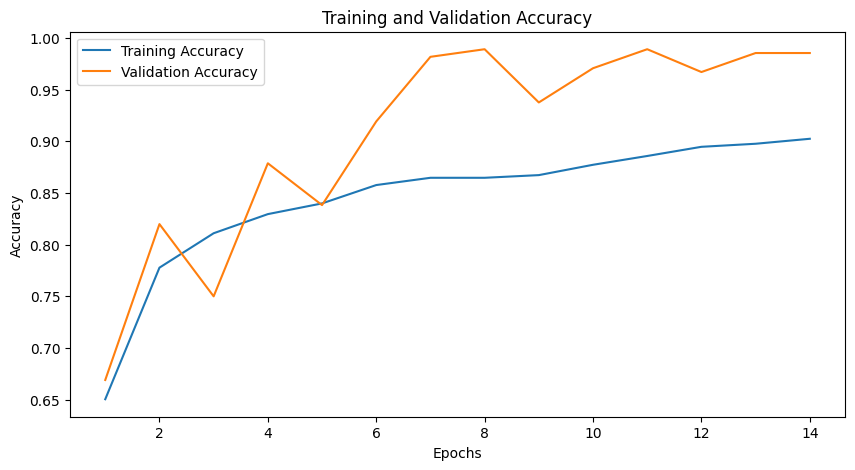

In [73]:
# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Generate range for epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step 
F1 Score: 0.9261
Precision: 0.8815
Recall: 0.9754

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.87      0.92       247
           1       0.88      0.98      0.93       244

    accuracy                           0.92       491
   macro avg       0.93      0.92      0.92       491
weighted avg       0.93      0.92      0.92       491



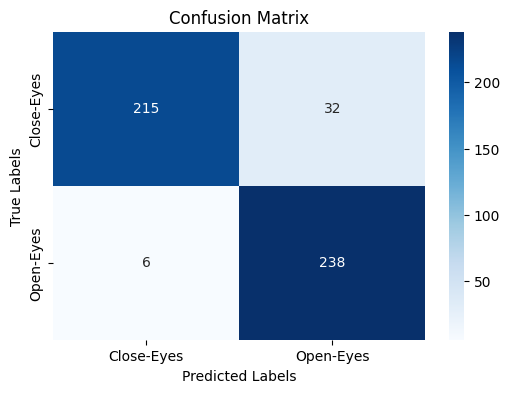

In [74]:
# Normalize test data
test_images = test_data

# Predict probabilities in bulk
y_pred_prob = model.predict(test_images, batch_size=batch_size)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5)

# Ensure test labels are 1D
y_true = test_labels

# # Debug shapes
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_true.shape)
# print("Predicted probabilities shape:", y_pred_prob.shape)
# print("Predicted labels shape:", y_pred.shape)

# # Ensure no shape mismatches
# assert len(y_true) == len(y_pred), "Mismatch between true labels and predicted labels!"

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [75]:
# Define the base model
base_model_eye = ResNet50(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the initial layers (experiment with different numbers of layers to unfreeze)
for layer in base_model_eye.layers[:140]:  # Freeze first 140 layers
    layer.trainable = False

# Add custom layers for binary classification
eye_input = Input(shape=(64, 64, 3), name='eye_input')
x_eye = base_model_eye(eye_input)
x_eye = GlobalAveragePooling2D()(x_eye)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_eye)
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
model = Model(inputs=eye_input, outputs=output)

# Compile the model (using default learning rate)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model checkpoint and early stopping with increased patience
checkpoint = ModelCheckpoint('best_resnet50_eye_model_intense.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,  # Training data generator with augmentation
    validation_data=val_gen,  # Validation data generator
    epochs=15,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"\nTest Loss: {test_loss:.4f}")
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.6527 - loss: 2.4296 - val_accuracy: 0.9853 - val_loss: 0.6204
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - accuracy: 0.7536 - loss: 0.9297 - val_accuracy: 0.9412 - val_loss: 0.3778
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 215ms/step - accuracy: 0.7839 - loss: 0.6169 - val_accuracy: 1.0000 - val_loss: 0.1138
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 246ms/step - accuracy: 0.8082 - loss: 0.5080 - val_accuracy: 1.0000 - val_loss: 0.0993
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.8293 - loss: 0.4314 - val_accuracy: 0.9963 - val_loss: 0.0913
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 251ms/step - accuracy: 0.8338 - loss: 0.4278 - val_accuracy: 0.9926 - val_loss: 0.0580
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.8266 - loss: 0.4235 - val_accuracy: 0.9522 - val_loss: 0.1388
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.8339 - loss: 0.3

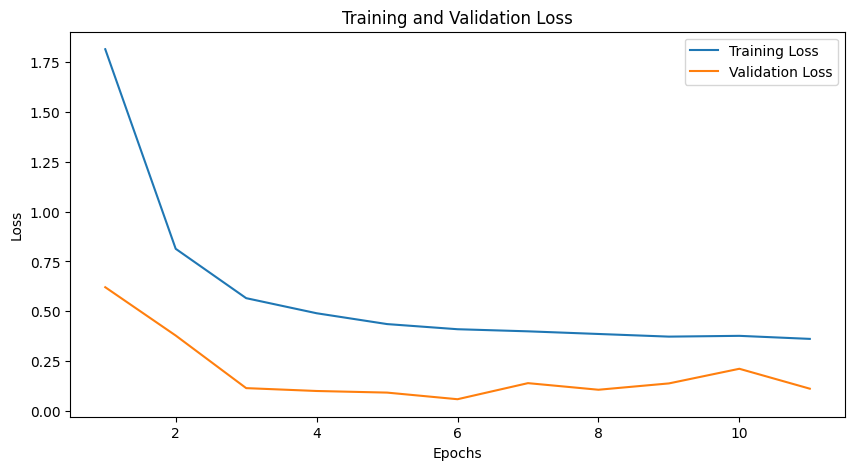

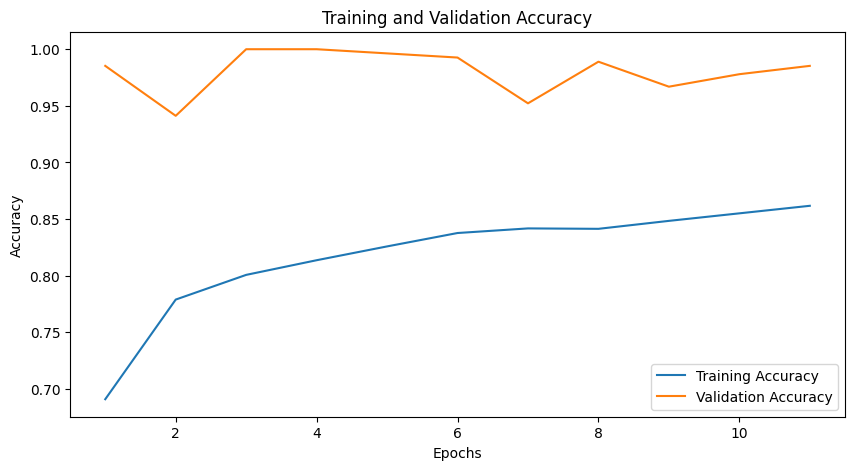

In [80]:
# Extract training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Generate range for epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step 
F1 Score: 0.8880
Precision: 0.8992
Recall: 0.8770

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       247
           1       0.90      0.88      0.89       244

    accuracy                           0.89       491
   macro avg       0.89      0.89      0.89       491
weighted avg       0.89      0.89      0.89       491



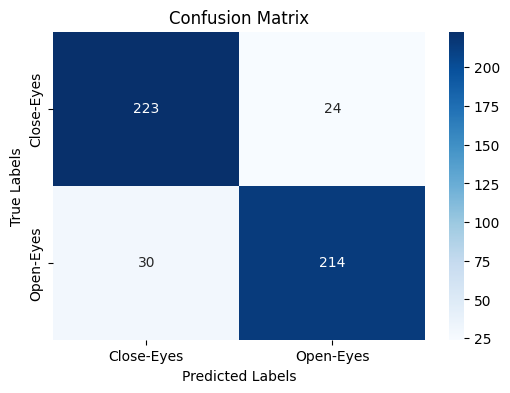

In [76]:
# Normalize test data
test_images = test_data

# Predict probabilities in bulk
y_pred_prob = model.predict(test_images, batch_size=batch_size)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5)

# Ensure test labels are 1D
y_true = test_labels

# # Debug shapes
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_true.shape)
# print("Predicted probabilities shape:", y_pred_prob.shape)
# print("Predicted labels shape:", y_pred.shape)

# # Ensure no shape mismatches
# assert len(y_true) == len(y_pred), "Mismatch between true labels and predicted labels!"

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# FaceNet

In [77]:
from keras_facenet import FaceNet

# Initialize FaceNet
embedder = FaceNet()


In [78]:
from keras_facenet import FaceNet

# Initialize FaceNet
embedder = FaceNet()

def generate_embeddings(data, labels, embedder):
    """
    Generate embeddings for a dataset using FaceNet.

    Parameters:
    - data: Array of face images (e.g., Open-Eyes and Close-Eyes).
    - labels: Corresponding labels for the images.
    - embedder: Pre-trained FaceNet model.

    Returns:
    - embeddings: Extracted FaceNet embeddings.
    - labels: Original labels corresponding to the embeddings.
    """
    embeddings = []
    for img in data:
        # Ensure the image is resized to (160, 160), the input size for FaceNet
        resized_img = cv2.resize(img, (160, 160))
        # Extract embedding
        embedding = embedder.embeddings([resized_img])
        embeddings.append(embedding[0])
    
    return np.array(embeddings), labels

# Generate embeddings for training, validation, and test sets
train_embeddings, train_labels = generate_embeddings(train_data, train_labels, embedder)
val_embeddings, val_labels = generate_embeddings(val_data, val_labels, embedder)
test_embeddings, test_labels = generate_embeddings(test_data, test_labels, embedder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 60s 60s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define a simple neural network classifier
classifier = Sequential([
    Dense(128, activation='relu', input_shape=(train_embeddings.shape[1],)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Open-Eyes vs Close-Eyes)
])

# Compile the classifier
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_facenet_model_NoA.keras', save_best_only=True)

# Train the classifier
classifier.fit(
    train_embeddings, train_labels,
    validation_data=(val_embeddings, val_labels),
    epochs=15,
    batch_size=16,
    callbacks=[checkpoint] # Apply callbacks during training

)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_embeddings, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


/Users/as/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.7694 - loss: 0.5456 - val_accuracy: 0.9382 - val_loss: 0.1904
Epoch 2/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8908 - loss: 0.2757 - val_accuracy: 0.9600 - val_loss: 0.1365
Epoch 3/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9130 - loss: 0.2178 - val_accuracy: 0.9600 - val_loss: 0.1100
Epoch 4/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9309 - loss: 0.1990 - val_accuracy: 0.9673 - val_loss: 0.0931
Epoch 5/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9245 - loss: 0.1864 - val_accuracy: 0.9636 - val_loss: 0.0922
Epoch 6/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9302 - loss: 0.1718 - val_accuracy: 0.9709 - val_loss: 0.0838
Epoch 7/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9410 - loss: 0.1555 - val_accuracy: 0.9673 - val_loss: 0.0791
Epoch 8/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9348 - loss: 0.1607 - val_ac

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Classification Metrics:
Precision: 0.9500
Recall: 0.9344
F1 Score: 0.9421

Confusion Matrix:
[[235  12]
 [ 16 228]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       247
           1       0.95      0.93      0.94       244

    accuracy                           0.94       491
   macro avg       0.94      0.94      0.94       491
weighted avg       0.94      0.94      0.94       491



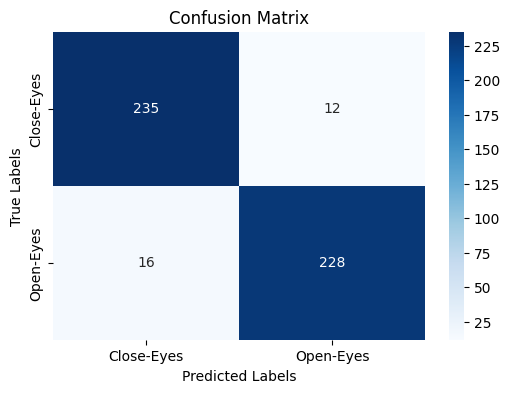

In [82]:
# Predict probabilities on the test set
y_pred_prob = classifier.predict(test_embeddings)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_prob > 0.5)

# Ensure test labels are in the correct shape
y_true = test_labels

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print results
print("\nClassification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Validation Accuracy: 0.9818
Test Accuracy: 0.9226

Classification Report (Test Set):
              precision    recall  f1-score   support

  Close-Eyes       0.92      0.93      0.92       247
   Open-Eyes       0.93      0.92      0.92       244

    accuracy                           0.92       491
   macro avg       0.92      0.92      0.92       491
weighted avg       0.92      0.92      0.92       491


Confusion Matrix (Test Set):
[[229  18]
 [ 20 224]]


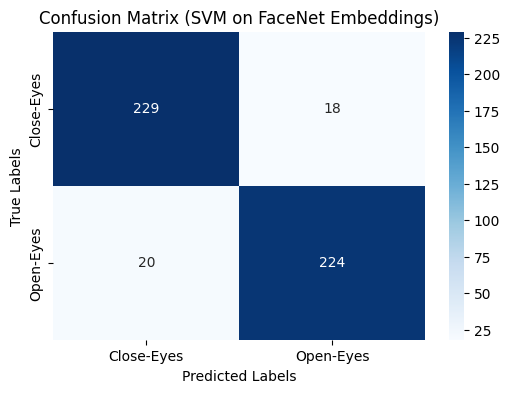

In [83]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')  # Adjust `C` and `gamma` if needed

# Train the SVM on the FaceNet embeddings
svm_classifier.fit(train_embeddings, train_labels)

# Validate the SVM classifier on the validation set
val_predictions = svm_classifier.predict(val_embeddings)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the SVM classifier on the test set
test_predictions = svm_classifier.predict(test_embeddings)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate a classification report for the test set
print("\nClassification Report (Test Set):")
print(classification_report(test_labels, test_predictions, target_names=["Close-Eyes", "Open-Eyes"]))

# Confusion matrix for the test set
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix (Test Set):")
print(conf_matrix)

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Close-Eyes", "Open-Eyes"], yticklabels=["Close-Eyes", "Open-Eyes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (SVM on FaceNet Embeddings)")
plt.show()